# Decicion tree learning: a look at _CART_
- (in the context of supervised, classification problems)

## A light backgroung on some machine learning terminology

_Supervised learning_
- The process of building a model that you can train using data for which the "answer" is already known

_Classification_
- Prediction of a class / label  - `yes, has cancer` or `no, does not have cancer` - and / or probability of data taking said label
- As opposed to the prediction of a numerical value - e.g. the price of a company’s stock in dollars (a regression problem)

_Model Selection_
- There are many different models one can use for predicting labels
- Which one you choose depends on many factors, including:
    - What are you trying to predict?
    - What kind of relationship (e.g. decision boundary) does it have to the variables you’re going to use to predict it? 
    - How much training data do you have?
    - How many features do you have and how many must you use?
    - Who are the end users?
    - Are there computational or implementation constraints?
- In general, you choose between bias and variance: whether you’re wrong or inconsistent, respectively




## What is decision tree learning?

_High level_
- Build a binary tree of rules through which a data point can be propagated so as to arrive at a prediction
- Each terminal node of the binary tree corresponds to a class label / probability
- Put differently, the goal is to partition the data into sets that correspond to the correct class label

_Advantages of decision tree models_
- You are freed from the shackles of linear relationship
- This allows for easy handling of both missing data in continuous variables - using extreme values outside of the range of the data - as well as outliers
- Decision trees can fit complex decision boundaries while still providing interpretability and reasonable computational costs
- Decision trees also produce well-calibrated classifiers
- I.e. you can consider the "scores" underlying the predicted labels for use as probability estimates

_Disadvantages_
- Overfitting - decision trees can couple themselves so tightly to the data that they're trained on that they lose the ability to generalize
- This can be dealt with through pruning (limiting the depth of the tree)
- Or through setting up an ensemble of different trees, as a _random forest_ would

## CART

_Background_
- Initialized as _CART_, Classification and Regression Trees is an algorithm for learning a decision tree off of training data
- This was developed by Leo Breiman and others
- This is a widely-accepted model for decision tree learning, currently implemented in, among other places, `scikit-learn` [docs](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier))
- For more detail, see _Classification and Regression Trees_ by Breiman, et al., from which the material here is sourced

_An attempt at a colloquial explanation of how CART works_
- At the top of the tree, you have a naive model: assign class probabilities simply by looking at the distribution of the classes in the data
- Your goal is to build a tree through iteratively selecting split points that lead to nodes that more clearly identify a particular class
- This should result in a number of terminal nodes that strongly point to membership in a particular class

_Put mildly more formally_
- Goal is to minimize impurity - i.e. we want nodes to become more pure to a certain class
- A node displays maximimum impurity if all class probabilities are even; minimum if 100% to a certain class
- The procedure I'm describing here is for a particular impurity function, or score used to for measuring split effectiveness
- And that's a measure called _Gini impurity_; there are other measures that can be used

_Build procedure_
- At each node, iterate through available features and each feature’s values, considering these as the possible options for splitting
- The split that provides the greatest reduction in impurity is selected
- This is a greedy algorithm: it works by selecting the locally optimal split at each iteration
- I.e. this does not evaluate all potential permutations of splits in the hopes of finding the globally optimal set of splits

_Pruning_
- Overfitting can be reduced / prevented by limiting the depth of the tree
- Originall this was done through running ex-post calculations on the tree to determine the optimal depth to leave it out
- `sklearn` implements a priori pruning; i.e. limit how far down the tree can go beforehand
- This can be done through saying either a certain minimum number of data points must lie at every node, or the tree can only grow to a certain depth

_Class weight_
- Unless class probabilities are evenly distributed, you will generally want the tree to scale each class's contribution to the impurity calculations by the inverse of their proportion in the data
- You can also pass different weights, if you want to emphasize a certain class, account for artificial resamplings 
- I.e. for dealing with severe class imbalances

## A walk-through on real data
- 1994 U.S. Census data - description found [here](https://archive.ics.uci.edu/ml/datasets/Adult)

In [79]:
import requests
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from indoorplants.validation.curves import validation_curve

In [2]:
%matplotlib inline

### Get data

In [3]:
def get_census_data():
    cols = ['age', 'workclass', 'fnlwgt', 'education', 
            'education_num', 'marital_status', 'occupation',
            'relationship', 'race', 'sex', 'capital_gain',
            'capital_loss', 'hours_per_week', 'native_country', 
            'over_fifty_k']
    
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    
    with requests.get(url, stream=True) as r:
        results = [l.decode().split(',') for l in r.iter_lines()]
    
    return pd.DataFrame(results, columns=cols)

### Quick look

In [6]:
df = get_census_data()

In [9]:
df.isnull().sum()

age               0
workclass         1
fnlwgt            1
education         1
education_num     1
marital_status    1
occupation        1
relationship      1
race              1
sex               1
capital_gain      1
capital_loss      1
hours_per_week    1
native_country    1
over_fifty_k      1
dtype: int64

In [10]:
df = df[df.notnull()].copy()

In [8]:
df.nunique()

age                  74
workclass             9
fnlwgt            21648
education            16
education_num        16
marital_status        7
occupation           15
relationship          6
race                  5
sex                   2
capital_gain        119
capital_loss         92
hours_per_week       94
native_country       42
over_fifty_k          2
dtype: int64

In [24]:
df.over_fifty_k.value_counts(normalize=True)

 <=50K    0.75919
 >50K     0.24081
Name: over_fifty_k, dtype: float64

### Data prep

In [49]:
(df.age == "").sum()

1

In [50]:
df = df[df.age != ""].copy()

In [51]:
int_cols = ["age", "hours_per_week"]

In [52]:
df[int_cols] = df[int_cols].astype(int)

In [53]:
flt_cols = ["capital_gain", "capital_loss", "fnlwgt"]

In [54]:
df[flt_cols] = df[flt_cols].astype(float)

In [63]:
obj_cols = list(filter(lambda x: x not in ("education_num", "over_fifty_k"),
                       df.select_dtypes(include=object).columns))

In [64]:
one_hot = pd.get_dummies(df[obj_cols])

In [65]:
X = df[int_cols + flt_cols].join(one_hot)

In [66]:
y = df.over_fifty_k.map(lambda _: 1 if _ == ' >50K'else 0)

### Cross-validate a decision tree over `max_depth`

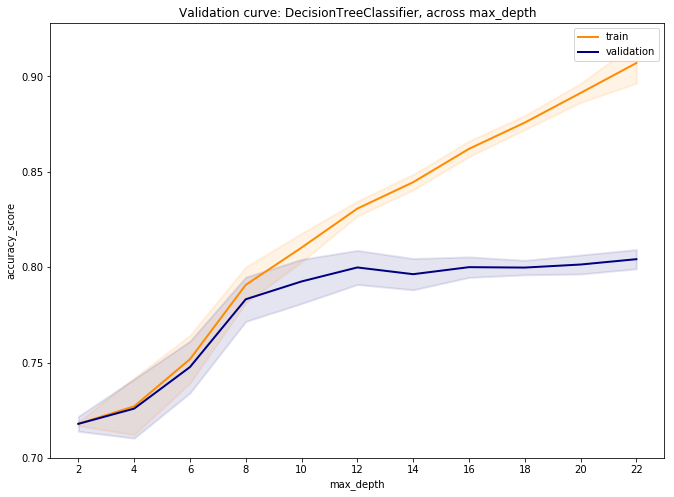

In [69]:
validation_curve(model_type=DecisionTreeClassifier,
                 X=X,
                 y=y,
                 param_name='max_depth',
                 param_range=list(range(2, 24, 2)),
                 other_params={"class_weight": "balanced"},
                 score=accuracy_score)

We can see that, as we let the tree go deeper, train and validation performance deviate severely - this is a classic example of _overfitting_.

### Feature importances

A useful analysis technique is to look at how much a given feature is contributing to the partitioning of the data. This is achieved through summing the impurity contributions at each split, by feature.

In [70]:
dt = DecisionTreeClassifier()

In [71]:
dt = dt.fit(X, y)

In [77]:
fi = pd.DataFrame(dt.feature_importances_, index=X.columns, columns=["gini_importance"])

In [78]:
fi.sort_values("gini_importance", ascending=False).head(10)

,gini_importance
marital_status_ Married-civ-spouse,0.197771
fnlwgt,0.187632
capital_gain,0.120635
age,0.117665
hours_per_week,0.063942
capital_loss,0.052959
education_ Bachelors,0.024095
occupation_ Prof-specialty,0.022789
occupation_ Exec-managerial,0.019408
workclass_ Private,0.010547
